In [1]:
# Environment Variables: 

YES = 1
NO = 0

In [2]:
# Google Drive:
using_google_drive = NO

if using_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
# Imports for Training

import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.preprocessing import StandardScaler
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client
from tqdm import tqdm
import tensorflow as tf

%matplotlib inline
output_scaler = StandardScaler()
print(tf.config.list_physical_devices('GPU'))

2024-12-31 04:47:24.377802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-31 04:47:24.434229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-31 04:47:24.434245: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-31 04:47:24.865025: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

[]


2024-12-31 04:47:25.442842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-31 04:47:25.445663: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-31 04:47:25.445701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-12-31 04:47:25.445731: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-12-31 04:47:25.445759: W tensorflow/c

In [4]:
# Read H5 Data File:
DATA_DIR = '/mnt/Research/Data/' # Change to your DATA PATH

RHEED_DATA_FILE = DATA_DIR + 'RHEED_4848_test6.h5'
spot = 'spot_2'
h5 = h5py.File(RHEED_DATA_FILE, 'r')

raw_data = []
for growth in h5.keys():
    raw_data.extend(h5[growth][spot])
raw_data = np.array(raw_data).astype(np.float32)

normalized_images = []
for image in raw_data:
    normalized_images.append(image / np.max(image))
normalized_images = np.array(normalized_images).astype(np.float32)

print(f'[Normalized Images Shape]: {normalized_images.shape}')

[Normalized Images Shape]: (150985, 48, 48)


[Normalized Image #131670]:


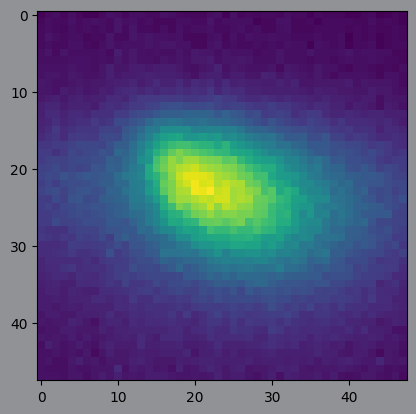

In [5]:
# Validate Data Array:
validate_data_array = YES

if validate_data_array:
    rand_int = np.random.randint(low=0, high=normalized_images.shape[0])
    print(f'[Normalized Image #{rand_int}]:')
    plt.imshow(normalized_images[rand_int])

In [6]:
# Functions for estimating labels

# generate 2d Gaussian from its parameters
# x, y = x-coord, y-coord
# A = amplitude
# x0, y0 = mean-x, mean-y
# sigma_x, sigma_y = std.-dev.-x, std.-dev.-y
def gaussian_2D(x, y, A, x0, y0, sigma_x, sigma_y):
    return A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))

# Initial guess for each parameter
# data = normalized image
def add_guess(data):
    A_guess = np.max(data)
    x0_guess, y0_guess = np.unravel_index(np.argmax(data), data.shape)
    sigma_x_guess = sigma_y_guess = np.std(data)
    return [A_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess]

# Compute residuals
# params = A, x0, y0, sigma_x, sigma_y
# x, y  = x-coord, y-coord
# data = normalized image
def residuals(params, x, y, data):
    A, x0, y0, sigma_x, sigma_y = params
    model = gaussian_2D(x, y, A, x0, y0, sigma_x, sigma_y)
    return (model - data).ravel()

# Convert parameters from A, x0, y0, sigma_x, sigma_y --> mean_x, mean_y, cov_x, cov_y, theta
# params = A, x0, y0, sigma_x, sigma_y
def convert_parameters(parameters):
    A, x0, y0, sigma_x, sigma_y = parameters
    mean_x = x0
    mean_y = y0
    cov_x = sigma_x
    cov_y = sigma_y

    if cov_x != 0 and cov_y != 0:
        theta = 0.5 * np.arctan(2 * cov_x * cov_y / (cov_x**2 - cov_y**2)+1e-9)
    else:
        theta = 0.0

    return mean_x, mean_y, cov_x, cov_y, theta

@delayed
def fit_gaussian_2D_delayed(data, guess):
    y, x = np.indices(data.shape)
    result = least_squares(residuals, guess, args=(x, y, data))
    return result.x


In [ ]:
# Estimate Labels:
load_labels = YES # (Takes <1 min to load, ~40 mins to generate)

# Import From File

if load_labels:
    RHEED_LABEL_FILE = DATA_DIR + 'Labels.npy'
    estimated_labels = np.load(RHEED_LABEL_FILE)
    # estimated_labels = np.random.rand(normalized_images.shape[0], 5)

# Generate
else:
    estimated_labels = []
    with Client() as client:
        guesses = [add_guess(image) for image in normalized_images]
        fits = [fit_gaussian_2D_delayed(image, guess) for image, guess in zip(normalized_images, guesses)]
        estimated_labels = [convert_parameters(params) for params in compute(*fits)]
    estimated_labels = np.array(estimated_labels).astype(np.float32)

print(f'[Estimated Labels Shape]: {estimated_labels.shape}')

[Estimated Labels Shape]: (150985, 5)


In [8]:
# Create DataSet:
batch_size = 1000

with tf.device('CPU'):
    dataset = tf.data.Dataset.from_tensor_slices(normalized_images)
    dataset = dataset.shuffle(normalized_images.shape[0], reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)

output_scaler.fit(estimated_labels)

2024-12-31 04:48:04.593257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-31 04:48:04.595840: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1391477760 exceeds 10% of free system memory.


StandardScaler()

In [9]:
# Gaussian Function: (TENSORFLOW)
print_example_guassian = NO

# mean_x, mean_y, cov_x, cov_y, theta
def generate_guassian(batch, image_shape):
    batch_size = batch.shape[0]
    mean_x, mean_y, cov_x, cov_y, theta = tf.unstack(batch, axis=-1)
    x = tf.range(image_shape[1], dtype=tf.float32)[:, tf.newaxis]
    x = tf.tile(x, [1, image_shape[0]])

    y = tf.range(image_shape[0], dtype=tf.float32)[tf.newaxis, :]
    y = tf.tile(y, [image_shape[1], 1])

    x = tf.tile(tf.expand_dims(x, 0), [batch_size, 1, 1])
    y = tf.tile(tf.expand_dims(y, 0), [batch_size, 1, 1])

    rota_matrix = tf.stack([tf.cos(theta), -tf.sin(theta), tf.sin(theta), tf.cos(theta)], axis=-1)
    rota_matrix = tf.reshape(rota_matrix, (batch_size, 2, 2))

    xy = tf.stack([x - tf.reshape(mean_x, (-1, 1, 1)), y - tf.reshape(mean_y, (-1, 1, 1))], axis=-1)
    xy = tf.einsum('bijk,bkl->bijl', xy, rota_matrix)

    img = tf.exp(-0.5 * (xy[:, :, :, 0]**2 / tf.reshape(cov_x, (-1, 1, 1))**2 + xy[:, :, :, 1]**2 / tf.reshape(cov_y, (-1, 1, 1))**2))

    return tf.expand_dims(img, axis=1)

if print_example_guassian:
    image_shape = (48, 48)
    batch = tf.convert_to_tensor([
        [21.8558168, 24.50041009, 10.31268177, 9.1700225, 0.72681534]
        , [21.76068143, 24.37956637, 10.30043488, 9.15426013, 0.72655111]
        , [21.72363929, 24.31050759, 10.33800891, 9.18570812, 0.72644599]
        , [21.72777699, 24.29306623, 10.30178808, 9.14728058, 0.72610718]
        , [21.79849472, 24.34649405, 10.32683150, 9.16259293, 0.72573213]
    ])
    generated_imgs = generate_guassian(batch, image_shape)
    plt.imshow(tf.squeeze(generated_imgs[0]))
    plt.show()

In [10]:
# Custom Loss Function (TENSORFLOW):
print_example_loss = YES

def custom_weighted_mse_loss(I, J, n):
  W = tf.pow(I, n)

  squared_diffs = tf.pow(I - J, 2)

  weighted_squared_diffs = W * squared_diffs

  loss = tf.reduce_mean(weighted_squared_diffs)

  return loss

if print_example_loss:
  I = tf.random.normal((5, 1, 48, 48))
  J = tf.random.normal((5, 1, 48, 48))
  n = 2
  loss = custom_weighted_mse_loss(I, J, n)
  print("[Custom Weighted MSE Loss]:", loss.numpy())

[Custom Weighted MSE Loss]: 3.9485857


In [11]:
# Model Architecture

model = tf.keras.Sequential(
    [   
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', input_shape=(48, 48, 1)) # (batch_size, height, width, channels)
        , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)
        , tf.keras.layers.ReLU()
        , tf.keras.layers.MaxPool2D(pool_size=4, strides=4)

        , tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid')
        , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)
        , tf.keras.layers.ReLU()
        , tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        , tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(units=98, activation='relu')
        , tf.keras.layers.Dense(units=52, activation='relu')
        , tf.keras.layers.Dense(units=5)
    ]
)

model.compile(optimizer='adam', loss=custom_weighted_mse_loss)

In [ ]:
# Training Loop
train_model = YES
save_model = NO
load_model = NO

if train_model:
    best_loss = float('inf')
    num_epochs = 200
    lr = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    n = 1

    for epoch in range(num_epochs):
        running_loss = 0.0

        if epoch % 10 == 0:
            n += 0.1

        for image_batch in tqdm(dataset): 
            image_batch = tf.expand_dims(image_batch, axis=3) # (batch_size, height, width, channels)
            with tf.GradientTape() as tape:
                embedding = model(image_batch)
                unscaled_param = tf.constant(embedding * output_scaler.var_ ** 0.5 + output_scaler.mean_)
                final = generate_guassian(unscaled_param, (48,48))
                loss = custom_weighted_mse_loss(image_batch, final, n)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            running_loss += loss.numpy()
        average_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

if save_model:
    model.save("Gaussian_Modle.keras")

if load_model:
    pass

model.summary()

In [14]:
# Imports for Quantizing

import qkeras
from qkeras.estimate import print_qstats
from qkeras.utils import model_quantize
from qkeras.utils import quantized_model_dump

In [ ]:
# Post Training Quantization
save_qmodel = NO

q_dict = {
    "QConv2D": {
        "kernel_quantizer": "quantized_bits(4,0,1)",
        "bias_quantizer": "quantized_bits(4,0,1)"
    },
    "QDense": {
        "kernel_quantizer": "quantized_bits(4,0,1)",
        "bias_quantizer": "quantized_bits(4,0,1)"
    },
    "QBatchNormalization": {},

    "QActivation": "quantized_relu(4,0)"
}

qmodel = model_quantize(model, q_dict, 4, transfer_weights=True)
print_qstats(qmodel)

if save_qmodel:
    qmodel.save("Quantized_Gaussian_Modle.keras")



Number of operations in model:
    conv2d                        : 290400 (smult_4_8)
    conv2d_1                      : 117600 (smult_4_4)
    dense                         : 14112 (smult_4_4)
    dense_1                       : 5096  (smult_4_4)
    dense_2                       : 260   (smult_4_4)

Number of operation types in model:
    smult_4_4                     : 137068
    smult_4_8                     : 290400

Weight profiling:
    conv2d_weights                 : 150   (4-bit unit)
    conv2d_bias                    : 6     (4-bit unit)
    conv2d_1_weights               : 2400  (4-bit unit)
    conv2d_1_bias                  : 16    (4-bit unit)
    dense_weights                  : 14112 (4-bit unit)
    dense_bias                     : 98    (4-bit unit)
    dense_1_weights                : 5096  (4-bit unit)
    dense_1_bias                   : 52    (4-bit unit)
    dense_2_weights                : 260   (4-bit unit)
    dense_2_bias                   : 5     (4-bit 

In [ ]:
# TODO: BENCHMARKS